In [ ]:
import pandas as pd
import random
from random import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torchsummary import summary
from sklearn.metrics import mean_squared_error
from __future__ import print_function
import itertools
from torch.utils.data import Dataset , DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
 # Load  data

# seed_indx=[1, 5, 9, 13]

dir='/content/drive/MyDrive/sensor_data/'
seed=5
x_train = np.load(dir+'x_train_'+str(seed)+'.npy')
y_train = np.load(dir+'y_train_'+str(seed)+'.npy')
x_test = np.load(dir+'x_test_'+str(seed)+'.npy')
y_test = np.load(dir+'y_test_'+str(seed)+'.npy')

In [ ]:
print(x_train.shape)

(1573979, 48)


In [ ]:
class SensorDataset(Dataset):

    def __init__(self, x, y):
        self.n_samples = x.shape[0]
        self.x_data = torch.from_numpy(x).float()
        self.y_data = torch.from_numpy(y).float()

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [ ]:
train_dataset = SensorDataset(x_train,y_train)
test_dataset = SensorDataset(x_test,y_test)

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size,drop_last=True)
test_dataloader = DataLoader(test_dataset,batch_size , drop_last=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim , hidden_size = hidden_size , num_layers= num_layers )
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn))
        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def predict(self,x):
        hn,cn  = self.init()
        final_out = self.fc(out[-1])
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0


In [ ]:
input_dim = 1
hidden_size = 50
num_layers = 6

model = Lstm_model(input_dim , hidden_size , num_layers).to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader):
    hn , cn = model.init()
    model.train()
    for batch , item in enumerate(dataloader):
        x , y = item
        y=torch.squeeze(y)
        x = x.to(device)
        y = y.to(device)
        # out , hn , cn = model(torch.unsqueeze(torch.t(x), 2),hn,cn) #pytorch compatible reshaping [time seq, batch, n_feat]
        out , hn , cn = model(x.reshape(48,batch_size,1),hn,cn)

        loss = loss_fn(out.reshape(batch_size), y)
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"train loss: {loss:>7f} ")

In [ ]:
def test(dataloader):
    hn , cn = model.init()
    model.eval()
    for batch , item in enumerate(dataloader):
        x , y = item
        y=torch.squeeze(y)
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(48,batch_size,1),hn,cn)
        # out , hn , cn = model(torch.unsqueeze(torch.t(x), 2),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)

        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"test loss: {loss:>7f} ")

In [ ]:
epochs = 50
for epoch in range(epochs):
    print(f"epoch {epoch} ")
    train(train_dataloader)
    test(test_dataloader)

epoch 0 
train loss: 249.658340 
test loss: 1420.976807 
epoch 1 
train loss: 58.216908 
test loss: 344.392395 
epoch 2 
train loss: 59.878159 
test loss: 328.693787 
epoch 3 
train loss: 58.366539 
test loss: 300.365814 
epoch 4 
train loss: 57.207581 
test loss: 294.532776 
epoch 5 
train loss: 59.218147 
test loss: 284.228149 
epoch 6 
train loss: 56.281017 
test loss: 284.158295 
epoch 7 
train loss: 57.488770 
test loss: 259.613861 
epoch 8 
train loss: 58.519989 
test loss: 266.515869 
epoch 9 
train loss: 59.767342 
test loss: 256.606323 
epoch 10 
train loss: 56.245949 
test loss: 252.729034 
epoch 11 
train loss: 57.612835 
test loss: 262.012787 
epoch 12 
train loss: 56.110771 
test loss: 256.814850 
epoch 13 
train loss: 53.596272 
test loss: 254.634964 
epoch 14 
train loss: 55.650444 
test loss: 286.761963 
epoch 15 
train loss: 54.795967 
test loss: 347.074982 
epoch 16 
train loss: 54.809959 
test loss: 234.561829 
epoch 17 
train loss: 60.519234 
test loss: 258.917053 


In [ ]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(48,64,1)
            pred = model(x,hn,cn)[0]
            pred=pred.cpu().detach().numpy()
            y=y.cpu().detach().numpy()
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
            # print(pred_arr,y_arr[21])

        print(pred_arr[21],y_arr[21])
        return y_arr, pred_arr

In [ ]:
y_arr, pred_arr=calculate_metrics(test_dataloader)

print(f"test mse loss {math.sqrt(mean_squared_error(y_arr,pred_arr))}")

[157.50533] [168.]
test mse loss 37.96775333054025


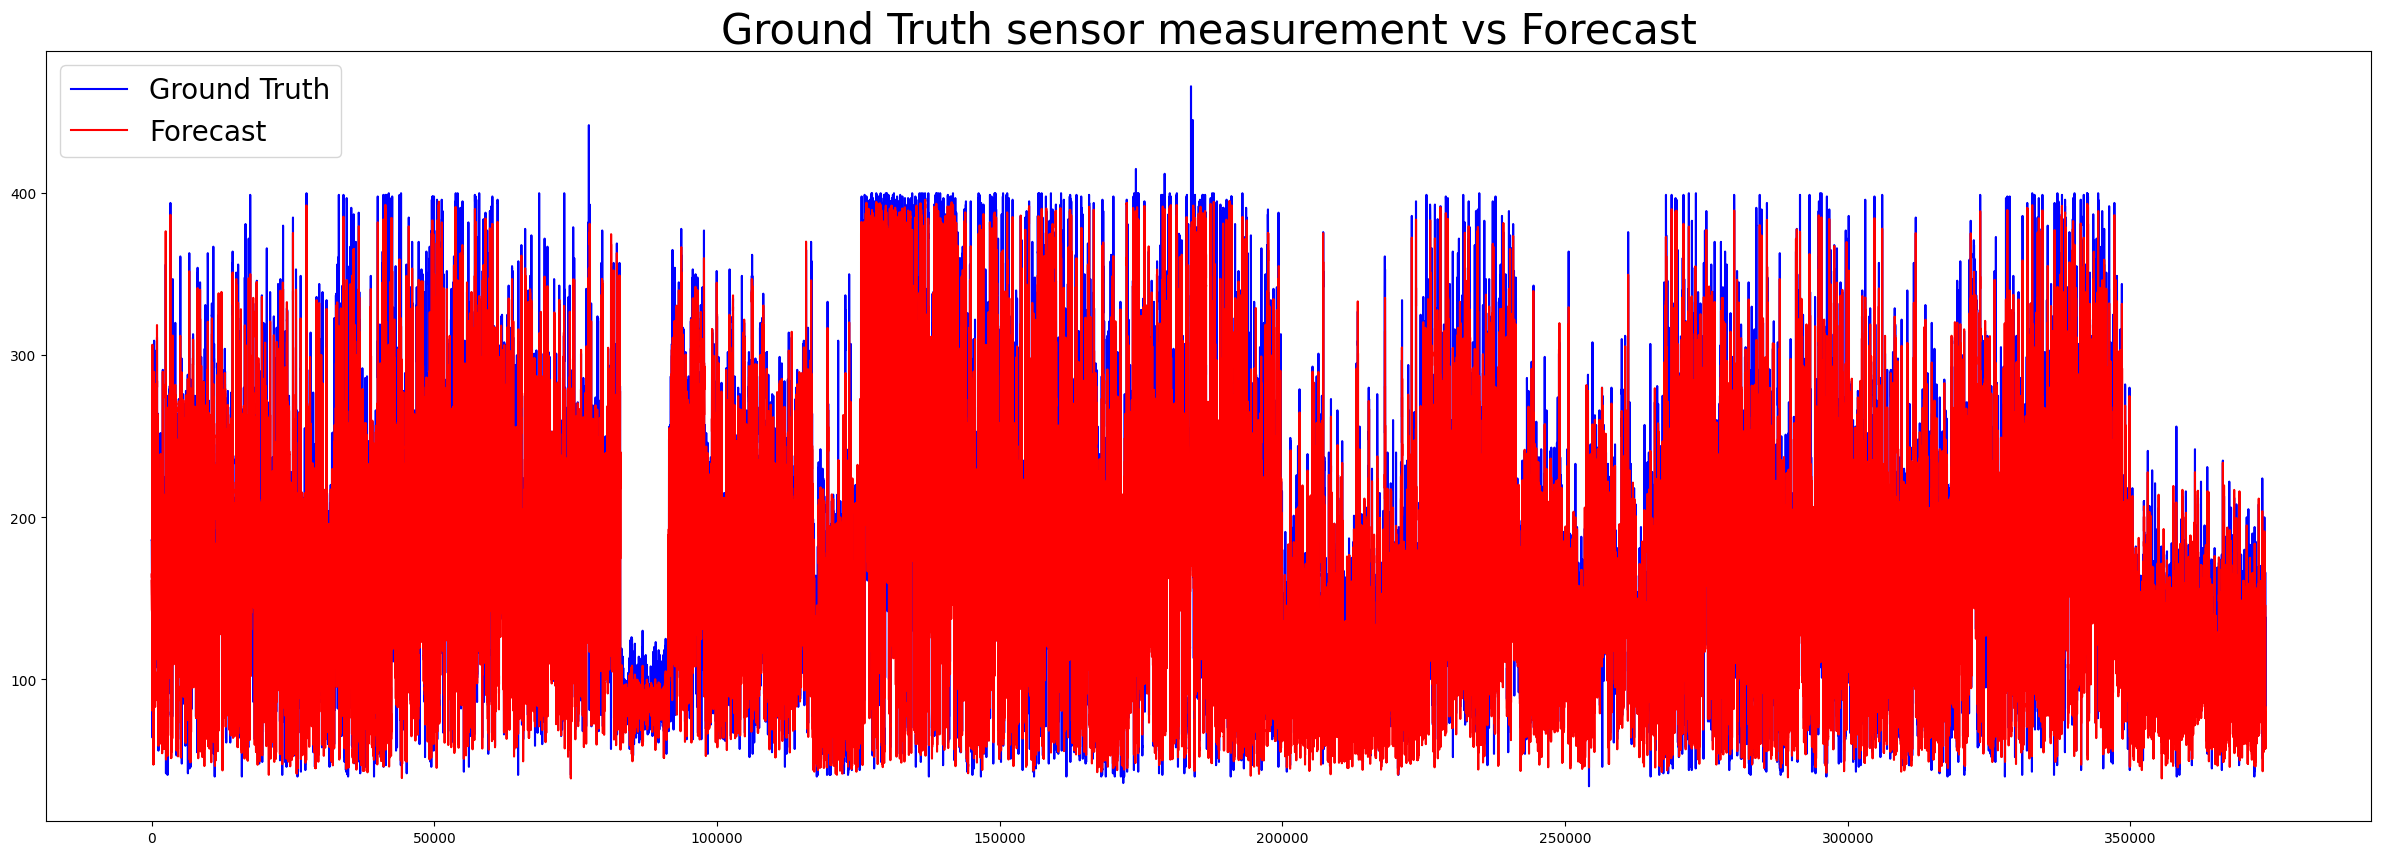

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Ground Truth sensor measurement vs Forecast', fontsize=30)
plt.plot([i for i in range(len(y_arr))], y_arr, "-b", label="Ground Truth")
plt.plot([i for i in range(len(pred_arr))], pred_arr, "-r", label="Forecast")
plt.legend(loc="upper left",fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.show()

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'